In [17]:
#HELPER FUNCTIONS
import time

def float_to_fixed18_bytes(value, verbose=False):
    """Convert float to 18-bit fixed-point (1 sign, 7 int, 10 frac) and return 3 bytes (LSB first)."""
    scaled = int(np.round(value * (2 ** 10)))  # Convert to fixed-point integer
    original_scaled = scaled  # Save for printing

    if scaled < 0:
        # Convert to 18-bit two's complement
        scaled = (1 << 18) + scaled

    b0 = scaled & 0xFF            # LSB
    b1 = (scaled >> 8) & 0xFF     # Middle byte
    b2 = (scaled >> 16) & 0xFF    # MSB (only lower 2 bits used)

    if verbose:
        print(f"\nThreshold float: {value}")
        print(f"Fixed-point scaled (int): {original_scaled} ({original_scaled & 0x3FFFF:#06x})")
        print(f"Bytes: b0 = {b0:#04x} ({b0:08b}), b1 = {b1:#04x} ({b1:08b}), b2 = {b2:#04x} ({b2:08b})")
        print(f"Reconstructed int18: {(b2 << 16) | (b1 << 8) | b0}")
        recon = original_scaled / (2 ** 10)
        print(f"Reconstructed float (approx): {recon:.5f}")

    return b0, b1, b2

def int_to_18bit_bytes(value, verbose=False):
    """Convert a non-negative integer to 18-bit representation, packed into 3 bytes (LSB first)."""
    assert value >= 0 and value < (1 << 18), "Value must be in range [0, 262143]"

    b0 = value & 0xFF          # LSB
    b1 = (value >> 8) & 0xFF   # Mid
    b2 = (value >> 16) & 0xFF  # MSB (only lower 2 bits used)

    if verbose:
        print(f"\nRefractory int: {value}")
        print(f"Bytes: b0 = {b0:#04x} ({b0:08b}), b1 = {b1:#04x} ({b1:08b}), b2 = {b2:#04x} ({b2:08b})")
        recon = (b2 << 16) | (b1 << 8) | b0
        print(f"Reconstructed int: {recon}")

    return b0, b1, b2

#Only needed for Debugging
def send_debug_params(a):
    if flag_DEBUG_en:
        serialPort.write(b'\x40')
        print("Debug params")
        time.sleep(0.01)  
        serialPort.write(b'\x00')  # I_BIAS
        time.sleep(0.001)
        serialPort.write(b'\x00')  # 
        time.sleep(0.001)
        serialPort.write(b'\x00')  # 
        time.sleep(0.001)
        
        serialPort.write(bytes([int(a)]))# N_debug_int
        # serialPort.write(b'\x01')  # N_debug_int
        time.sleep(0.001)
        serialPort.write(b'\x00')  # 
        time.sleep(0.001)
        serialPort.write(b'\x00')  # 
        time.sleep(0.001)
        print("sent n-debug#", a)


#Function to recieve spikes data from the FPGA
def recieve_data_from_FPGA(result_queue):
    global receiver_stop_flag
    if flag_Recieving_SPIKES==1:
        bit_stream = []
        bytess = []
        # print("Start recieving")
        # Step 1: Wait for start marker 0xFF
        start_marker_detected = False
        while not start_marker_detected:
            if serialPort.in_waiting:
                byte = serialPort.read()
                if byte[0] == 0xFF:
                    start_marker_detected = True
                    print("Start marker detected!")
        
        # while receiver_stop_flag == 0:
        # while len(bit_stream)<=2880:
        # expected_bytes = 360
        # while len(bytess) < expected_bytes:
        while receiver_stop_flag == 0:
            if serialPort.in_waiting:
                byte = serialPort.read()
                bytess.append(byte)
                # byte_val = byte[0]
                # for i in range(8):  # LSB-first
                #     bit_stream.append((byte_val >> i) & 0x01)
        # print(f"Received {len(bytess)} bytes")

        # Step 3: Unpack bytes into bits
        for byte in bytess:
            byte_val = byte[0]
            for i in range(8):  # LSB first
                bit_stream.append((byte_val >> i) & 0x01)
        
        # print(f"Total bits received: {len(bit_stream)} bits")
        serialPort.close()
        # print(len(bytess))
        
        # print("Start decoding with overlap-aware unpacking")
        
        # Reconstruct 14-bit frames accounting for overlap
        # N_actual = 14
        spike_frames = []
        bit_buffer = []
        
        for bit in bit_stream:
            bit_buffer.append(bit)
            if len(bit_buffer) >= N_actual:
                frame = bit_buffer[:N_actual]
                spike_frames.append(frame)
                bit_buffer = bit_buffer[N_actual:]  # remove used bits, keep overlap
        
        # Convert to NumPy array
        spike_array = np.array(spike_frames).T  # shape: (96, T)
        
        # print(f"Spike matrix shape: {spike_array.shape}")
        
        # Plot raster
        if flag_plot_raster:
            plt.figure(figsize=(10, 4))
            for neuron_idx in range(N_actual):
                if neuron_idx<num_raster:
                    spike_times = np.where(spike_array[neuron_idx] == 1)[0]
                    plt.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 0.6, color="black")
            
            plt.xlabel('Timestep')
            plt.ylabel('Neuron Index')
            # plt.title('Spike Raster Plot (Overlap-aware)')
            # plt.yticks(range(1, N_actual + 1))
            plt.yticks(range(1, num_raster + 1))
            plt.grid(True, linestyle='--', alpha=0.3)
            
            # plt.tight_layout()
            plt.show()              
        result_queue.put(spike_array)

# === SEND Weights, neuron, synapse, and learning parameters ===
def send_weights_and_params():
    if flag_AA_en:
        serialPort.write(b'\x10')  # AA command
        print("Sending AA")
        time.sleep(0.01)
        weights_bytes_AA = bytes(flat_weights_AA)
        serialPort.write(weights_bytes_AA)                 
        
        serialPort.write(b'\x00')
        
    if flag_FF_en:
        serialPort.write(b'\x00')  # FF command
        print("Sending FF")     
        weights_bytes_FF = bytes(flat_weights_FF)
        serialPort.write(weights_bytes_FF) 
        
        serialPort.write(b'\x00')

    if flag_STDP_en:
        serialPort.write(b'\x60')  # FF command
        print("Sending STDP enable matrix")
        for byte in uart_packets_AA:
            serialPort.write(bytes([byte]))
        for byte in uart_packets_FF:
            serialPort.write(bytes([byte]))
        serialPort.write(b'\x00')
    
    if flag_DUMMY_DATA or flag_DIGITS_DATA:
        if flag_Thr_en:
            serialPort.write(b'\x20')  # Threshold command
            print("Sending Thr")
            time.sleep(0.001)
            for thr in Threshold_scaled:
                b0, b1, b2 = float_to_fixed18_bytes(thr)
                serialPort.write(bytes([b0]))
                time.sleep(0.001)
                serialPort.write(bytes([b1]))
                time.sleep(0.001)
                serialPort.write(bytes([b2]))
                time.sleep(0.001)
                
            print("Sending Tref")
            for ref in Ref_period:
                b0, b1, b2 = int_to_18bit_bytes(ref)
                serialPort.write(bytes([b0]))
                time.sleep(0.001)
                serialPort.write(bytes([b1]))
                time.sleep(0.001)
                serialPort.write(bytes([b2]))
                time.sleep(0.001)
                
            print("Sending Tau_mem")
            for val in Leak:
                b0, b1, b2 = float_to_fixed18_bytes(val)
                serialPort.write(bytes([b0]))
                time.sleep(0.001)
                serialPort.write(bytes([b1]))
                time.sleep(0.001)
                serialPort.write(bytes([b2]))
                time.sleep(0.001)
            
            print("Sending STDP_params")
            serialPort.write(b'\x7f')  # tpre_FF_max value
            time.sleep(0.001)
            serialPort.write(b'\x7f')  # tpost_FF_max value
            time.sleep(0.001)
            serialPort.write(b'\x00')  # 
            time.sleep(0.001)
            serialPort.write(b'\x7f')  # tpre__AA_max value
            time.sleep(0.001)
            serialPort.write(b'\x7f')  # tpost_AA_max value
            time.sleep(0.001)
            serialPort.write(b'\x7f')  # 
            time.sleep(0.001)             
            for _ in range(N-2):
                # serialPort.write(bytes([int(0)]))
                serialPort.write(b'\x01')  # delta_w 
                time.sleep(0.001)
                serialPort.write(b'\x01')  # 
                time.sleep(0.001)
                serialPort.write(b'\x00')  # 
                time.sleep(0.001)           

# === RUN SIMULATION ===
# === RUN SIMULATION ===
def run_simulation(NA, spike_array):
    global receiver_stop_flag
    if flag_DUMMY_DATA:
        if flag_NIST_en:
            # Prepare the big data buffer
            send_buffer = bytearray()
            dt=5
            for _ in range(1):
                # for n_address in range(NA,Y+1,1):
                for n_address in range(2,5,1):
                    # print(xxx,dt, type(xxx), type(dt))
                    send_buffer.append(dt)       # relative time
                    send_buffer.append(n_address)   # neuron index
                    send_buffer.append(0x00)      # padding
            # Append FF markers (stop signal)
            send_buffer.extend([0xFF, 0xFF, 0xFF])
            serialPort.write(b'\x30')  # Start NIST command
            print("Sending Spike Data")
            serialPort.write(send_buffer)            
            time.sleep(0.1)
            receiver_stop_flag=1
            # print("Done Spike Data", receiver_stop_flag)

    if flag_DIGITS_DATA:
        if flag_NIST_en:

            # print("Sending Spike Data")
            # times, neurons = np.nonzero(spike_array)
            times, neurons = zip(*spike_array)
            # print("Times", times)
            # print("Neurons", neurons)
            neurons = np.array(neurons)
            times = np.array(times)
            times=times-times[0]
            neuron_indices = (neurons.astype(np.uint8)+ 2).astype(np.uint8) #neurons.tolist()
            time_indices = times.astype(np.uint8) #times.tolist()
            relative_time_diffs = [time_indices[0]] + [t2 - t1 for t1, t2 in zip(time_indices[:-1], time_indices[1:])]
            relative_time_diffs = [0 if val == 1 else val for val in relative_time_diffs]
            # relative_time_diffs = np.array(relative_time_diffs, dtype=np.uint8)
            relative_time_diffs = np.clip(relative_time_diffs, 0, 255).astype(np.uint8)
        
            # Prepare the big data buffer
            send_buffer = bytearray()
            for dt, neuron in zip(relative_time_diffs, neuron_indices):
                send_buffer.append(dt)       # relative time
                send_buffer.append(neuron)   # neuron index
                send_buffer.append(0x00)      # padding

            # Append FF markers (stop signal)
            send_buffer.extend([0xFF, 0xFF, 0xFF])
            # Start sending data
            serialPort.write(b'\x30')  # Start NIST command
            serialPort.write(send_buffer)            
            time.sleep(1)
            # print("Sent STOP, waiting 1 sec")
            receiver_stop_flag= 1
            # print("Sent STOP flag",receiver_stop_flag)


**#Import SNN model from Superneuromat**

In [18]:
#Import SNN model's parameters and DIGITS dataset.
#Requires installation of Superneuromat. 
# Use pip install superneuromat.

import superneuromat as snm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import queue
import json 
from json import loads

from sklearn.datasets import load_digits
# import pickle

from sklearn.model_selection import train_test_split

np.random.seed(42)
infer_model=snm.SNN()
with open('digits.snn.json') as f:
    file = f.read()

j = loads(file)
infer_model.from_jsons(file)

input_indices = j['extra']['input_indices']
output_indices = j['extra']['output_indices']
period = j['extra']['period']
encoding_period = j['extra']['encoding_period']

inputs_spikes = [
    (time, dest)
    for time, spike_vec in enumerate(infer_model.spike_train)  # spike_vec is a binary vector of spikes from each neuron
    for dest, did_spike in zip(input_indices, spike_vec[input_indices])
    if did_spike
]

digits = load_digits()

data = digits.data
digit_labels = digits.target
labels = np.unique(digits.target)
n_labels = len(labels)

n_inputs = digits.data.shape[-1]
X_train, X_test, y_train, y_test = train_test_split(data, digit_labels, test_size=0.5, shuffle=False)

times, neurons = zip(*inputs_spikes)
spikes_copy = inputs_spikes.copy()
batched_spikes = [[]]
for spike in spikes_copy:
    t, dest = spike
    batch_id = t // period
    # print(batch_id)
    while batch_id >= len(batched_spikes):
        batched_spikes.append([])
    batched_spikes[batch_id].append(spike)
digits_test_spike_trains=batched_spikes


**#Setup Serial Communication**

In [19]:
import serial
import time
import matplotlib.pyplot as plt
from collections import deque
import threading
import queue
import numpy as np

# === CONFIGURATION ===
SERIAL_PORT = 'COM4'       # Replace with your actual port
BAUD_RATE = 1000000 #1000000
N = 96#20      
N_actual=N-6 #90 Neurons

# === FLAGS ===
flag_AA_en = 1
flag_FF_en = 1
flag_Thr_en = 1
flag_NIST_en = 1
flag_READ_en = 1
flag_DEBUG_en=1
flag_STDP_en=1

flag_Recieving_SPIKES=1

flag_DUMMY_DATA=0
flag_DIGITS_DATA=1
flag_plot_raster=0

num_raster=11 #Number of neurons to plot on the raster plot out of N neuorns on the FPGA. DIGITS needs 10

############DIGITS DATASET#################
n_in=64
N_model=10

**#Read Model weights from Superneuromat**

In [21]:
#Set up Network weights refered to as Weight_AA
scaling_factor_FPGA=1
if flag_DUMMY_DATA or flag_DIGITS_DATA: #Program as per need
    start_row = 6
    start_col = 5
    diag_size = N_actual  # 90x90 diagonal submatrix   
#######Initializes a square matrix weights_AA of zeros and set the diagonal elements of that matrix to weight_D
    winit=0
    weights_AA = np.ones((N_model, N_model))*winit
    # Set the value
    weight_D = 0  # (or whatever value you want)    
    for start_col in range(0, N_model, N_model):
        end_col = start_col + N_model
        if end_col <= N_model:
            for i in range(N_model):
                weights_AA[i, start_col + i] = weight_D
# Scale if needed
weights_AA_scaled = weights_AA*scaling_factor_FPGA

# Clip to int8 range
weights_AA_scaled = np.clip(weights_AA_scaled, -128, 127)
padded_matrix_AA = np.zeros((N, N), dtype=np.int8)
padded_matrix_AA[start_row:N_model+start_row, start_col:N_model+start_col] = weights_AA_scaled
flat_weights_AA=padded_matrix_AA.flatten()

#Set up Inputs_Weights refered to as W_FF
scaling_factor_FPGA=1
if flag_DIGITS_DATA:
    start_row = 6
    start_col = 2
    end_row=N-N_model-start_row
    end_col=N-n_in-start_col
    weights_FF=infer_model.weight_mat()[:64, 64:]
    
    weights_FF=weights_FF.T


# Scale first
weights_FF_scaled = weights_FF*scaling_factor_FPGA
#Clip to int8 range
weights_FF_scaled = np.clip(weights_FF_scaled, -128, 127)
padded_matrix_FF = np.zeros((N, N), dtype=np.int8)
padded_matrix_FF[start_row:-end_row, start_col:-end_col] = weights_FF_scaled
flat_weights_FF=padded_matrix_FF.flatten()

**#Read Neuron Parameters from Superneuromat model**

In [23]:
#Read Neuron Parameters for the neurons on the FPGA
Leak = np.array(infer_model.neuron_leaks [n_in:])*0
Ref_period=np.array(infer_model.neuron_refractory_periods[n_in:])
Threshold= np.array(infer_model.neuron_thresholds[n_in:])
Threshold_scaled=np.clip(Threshold*scaling_factor_FPGA, 0,10027)
Leak_scaled=Leak*scaling_factor_FPGA

FPGA_start_neuron_offset=4
End_padding=N-N_model-FPGA_start_neuron_offset
# Leak=np.zeros(10)
Leak = np.concatenate((np.zeros(4, dtype=Leak.dtype), Leak_scaled, np.zeros(End_padding, dtype=Leak.dtype)))
Ref_period = np.concatenate((np.ones(4, dtype=Ref_period.dtype)*1, Ref_period, np.zeros(End_padding, dtype=Ref_period.dtype)))
Threshold_scaled = np.concatenate((np.ones(4, dtype=Threshold.dtype)*127, Threshold_scaled, np.ones(End_padding, dtype=Threshold.dtype)*127))

**#Enable/Disable STDP on individual synapses**

In [26]:
#Setup bits STDP enable filter, if all zeros, STDP is disabled for all synapses
#DIGITS doesn't need STDP hence we set the flags to 0
# Step 1: Extract and convert to binary (if needed)
matrix = infer_model.stdp_enabled_mat(np.uint8)  # Assuming it's a 2D NumPy array or similar
binary_matrix = (np.array(matrix) > 0).astype(np.uint8)  # Ensure values are 0 or 1
# print(binary_matrix.shape, binary_matrix.dtype)
stdp_en_AA=binary_matrix
# stdp_en_AA=np.zeros((N_actual,N_actual))

padded_stdp_enable_matrix_FF=np.zeros((N,N))
# padded_stdp_enable_matrix_FF[6:-80, 2:-30]=stdp_en_FF

padded_stdp_enable_matrix_AA=np.zeros((N,N))
# padded_stdp_enable_matrix_AA[6:, 5:-1]=stdp_en_AA

# Assume model._stdp_enabled_synapses is your matrix (N x N)
synapse_matrix_FF = padded_stdp_enable_matrix_FF#model._stdp_enabled_synapses
synapse_matrix_AA = padded_stdp_enable_matrix_AA#model._stdp_enabled_synapses

# Step 1: Flatten in row-major order (default in NumPy)
flat_bits_FF = synapse_matrix_FF.flatten().astype(np.uint8)
flat_bits_AA = synapse_matrix_AA.flatten().astype(np.uint8)
# print(flat_bits_AA.dtype)
# Step 2: Pad to make total bit count divisible by 8
padding = (8 - (flat_bits_FF.size % 8)) % 8
if padding > 0:
    print("CHECK THIS")
    flat_bits_FF = np.concatenate([flat_bits_FF, np.zeros(padding, dtype=np.uint8)])
    flat_bits_AA = np.concatenate([flat_bits_AA, np.zeros(padding, dtype=np.uint8)])

# Step 3: Reshape to (num_bytes, 8)
bit_groups_FF = flat_bits_FF.reshape(-1, 8)
bit_groups_AA = flat_bits_AA.reshape(-1, 8)

# Step 4: Pack LSB-first
bytes_list_FF = []
bytes_list_AA = []
for bits in bit_groups_FF:
    byte = 0
    for i, bit in enumerate(bits):  # LSB-first: bit[0] goes to b0
        byte |= (bit << i)
    bytes_list_FF.append(byte)

for bits in bit_groups_AA:
    byte = 0
    for i, bit in enumerate(bits):  # LSB-first: bit[0] goes to b0
        byte |= (bit << i)
    bytes_list_AA.append(byte)

# Final byte array
uart_packets_FF = np.array(bytes_list_FF, dtype=np.uint8)
uart_packets_AA = np.array(bytes_list_AA, dtype=np.uint8)

**#Run emulation on NeuroCoreX**

Debug params
sent n-debug# 1
Sending AA
Sending FF
Sending STDP enable matrix
Sending Thr
Sending Tref
Sending Tau_mem
Sending STDP_params
Test image 0
Start marker detected!


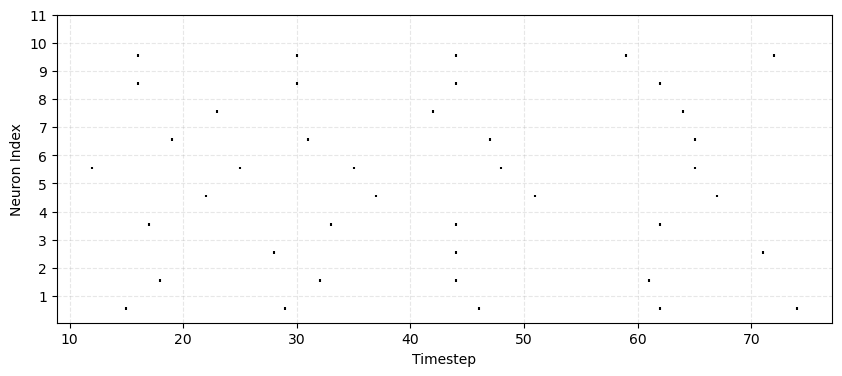

Test image 1
Start marker detected!


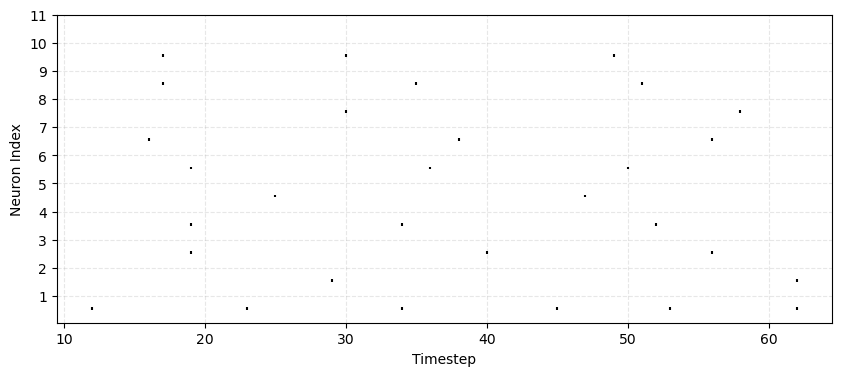

Test image 2
Start marker detected!


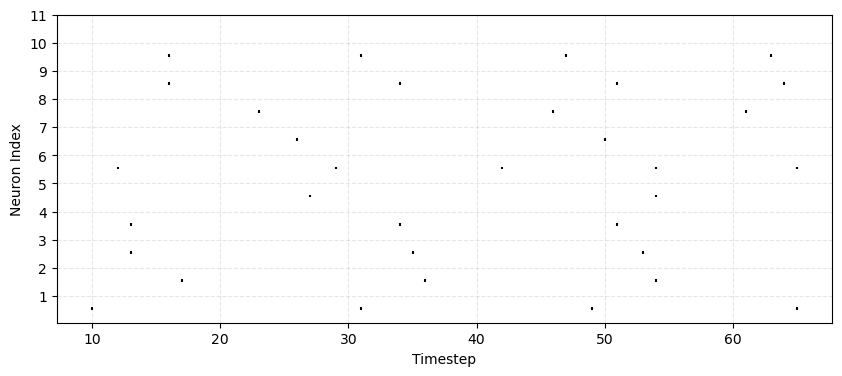

Test image 3
Start marker detected!


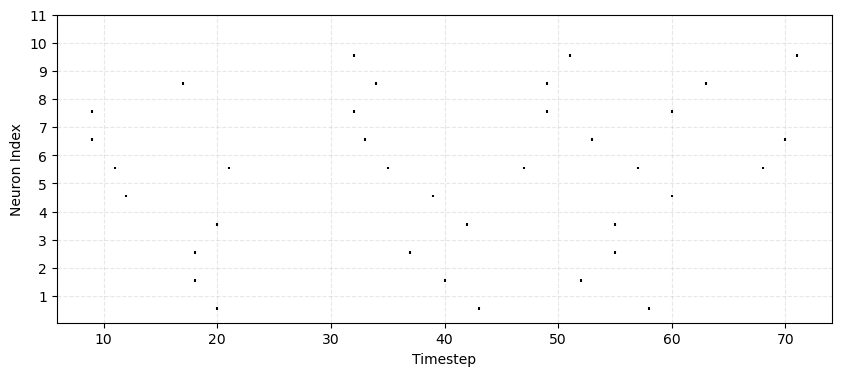

Test image 4
Start marker detected!


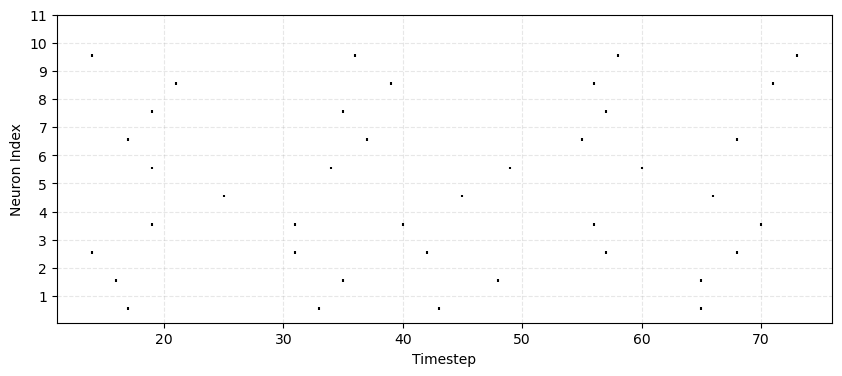

In [27]:
###RUN SNN EMULATION
# serialPort.close()
spike_array_list=[]
flag_STDP_en=1
serialPort = serial.Serial(SERIAL_PORT, BAUD_RATE)
serialPort.reset_input_buffer()
serialPort.reset_output_buffer()
send_debug_params(1)
send_weights_and_params()
flag_plot_raster=1

global receiver_stop_flag

for j in range(len(digits_test_spike_trains)):
    if j<5:

        if j>0:
            serialPort = serial.Serial(SERIAL_PORT, BAUD_RATE)
        ####Input test spike trains from DIGITS##################################
        if len(digits_test_spike_trains[j])>0:
            spike_array=np.array(digits_test_spike_trains[j])
            N_debug=int(j)
            NA=2
            print("Test image",j)
            # print(spike_array)
            times, neurons = zip(*spike_array)            
            result_queue = queue.Queue()
            receiver_stop_flag=0
            
            # Flush buffers before receiving
            serialPort.flushInput()
            serialPort.reset_input_buffer()
            serialPort.reset_output_buffer()
            thread1 = threading.Thread(target=recieve_data_from_FPGA, args=(result_queue,))
            thread1.start()
            # time.sleep(2)
            # print("Now starting")
            run_simulation(NA, spike_array) #First two arguments unused
            received_data = result_queue.get()
            thread1.join()
            spike_array_list.append(received_data)
        else:
            serialPort.close()        

**#Read Weights back from NeuroCoreX**

In [28]:
# This function is used to read the weights of the all-to-all connected network back from the FPGA.

def send_dummy_data_read_weights():
    if flag_READ_en:
        serialPort.write(b'\x50')  # Read weights command
        # print("Sending dummy_data")
        for _ in range(1): #(N * N)+3
            serialPort.write(b'\x7a')  # FF weight
            # time.sleep(0.01)
    print("Receiving weights...")
    
def read_weights_from_FPGA(result_queue):
    received_weights = []
    while len(received_weights) < NUM_WEIGHTS-1:
        # Read incoming bytes until all weights are received
        if serialPort.in_waiting:
            byte = serialPort.read()
            if byte:
                # print(byte, len(received_weights))
                signed_value = int.from_bytes(byte, byteorder='little', signed=True)
                received_weights.append(signed_value)
    result_queue.put(received_weights)

# Shared queue to get result from thread
result_queue = queue.Queue()

NUM_WEIGHTS = N * N
serialPort = serial.Serial(SERIAL_PORT, BAUD_RATE)
flag_READ_en=1
# send_weights_and_params()
serialPort.reset_input_buffer()
serialPort.reset_output_buffer()
time.sleep(1)
thread2 = threading.Thread(target=read_weights_from_FPGA, args=(result_queue,))
thread2.start()
time.sleep(1)
serialPort.reset_input_buffer()
send_dummy_data_read_weights()
thread2.join()

# Get the result from the queue
received_weights = result_queue.get()
serialPort.close()
received_weights.append(0) #To reshape, last weight from FPGA is dummy (not participating in the calculations) hence zero.
# Convert to 2D matrix
weight_matrix = np.array(received_weights, dtype=np.int8).reshape((N, N))
# print(weight_matrix)
Desired_weight_matrix_AA=weight_matrix[start_row:-end_row, start_col:-end_col]
print(Desired_weight_matrix_AA)

Receiving weights...
[[-2 -2 -2  6  5 -1 -2 -2 -2 -2  5  6  5  5 -2 -2 -2 -1  6  0 -1  5 -1 -2
  -2  0  5 -2 -2  3  1 -2 -2  0  6 -2 -2  3  2 -2 -2 -2  6 -1 -2  5  0 -2
  -2 -2  6  4  4  6 -2 -2 -2 -2 -1  6  6  0 -2 -2]
 [-2 -2 -2  2  4  2 -2 -2 -2 -2 -1  4  5  3 -1 -2 -2 -2  0  6  5  3 -2 -2
  -2 -2  3  6  6  1 -2 -2 -2 -2  2  4  6  0 -2 -2 -2 -2  0  3  6  1 -2 -2
  -2 -2  0  3  6  2 -1 -2 -2 -2 -2  2  5  3 -1 -2]
 [-2 -2  2  5  3 -1 -2 -2 -2  0  5  5  5  0 -2 -2 -2  0  2  0  5  0 -2 -2
  -2 -2 -1  0  5  0 -2 -2 -2 -2 -1  4  3 -2 -2 -2 -2 -2  1  5  0 -2 -2 -2
  -2 -2  4  6  5  4  0 -2 -2 -2  2  5  6  5  1 -2]
 [-2 -2  2  6  6  1 -2 -2 -2 -1  5  4  5  4 -1 -2 -2 -1  0 -1  5  3 -2 -2
  -2 -2 -2  2  6  0 -2 -2 -2 -2 -2  0  5  4 -2 -2 -2 -2 -2 -2  0  6  0 -2
  -2 -2  1  2  3  5  0 -2 -2 -2  2  6  6  2 -1 -2]
 [-2 -2 -2  1  4 -2 -2 -2 -2 -2 -1  5  2 -1 -2 -2 -2 -2  3  4  1  1 -2 -2
  -2 -1  6  0  2  3  0 -2 -2  2  6  3  6  5  0 -2 -2  0  4  5  6  3 -2 -2
  -2 -2 -1  2  5 -1 -2 -2 -2 -2 -2 